### Import lib

In [1]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import transformers
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from PIL import Image
from torch.utils.data import DataLoader
import random
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
dir_path = Path("/kaggle/input/brain-tumor-mri-dataset")

# train_dir = dir_path/"train"
# test_dir = dir_path/"test"

#For kaggle
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [6]:
images = list(dir_path.glob("*/*/*.jpg"))
images[:10]

[PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg')]

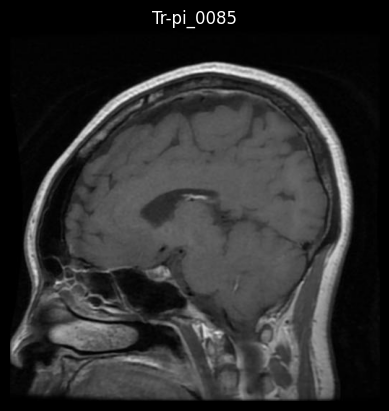

In [7]:
random_image = random.choice(images)
title = random_image.stem
img = Image.open(random_image)
plt.figure(facecolor="black")
plt.imshow(img)
plt.title(title,color="white")
plt.axis("off")
plt.show()

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

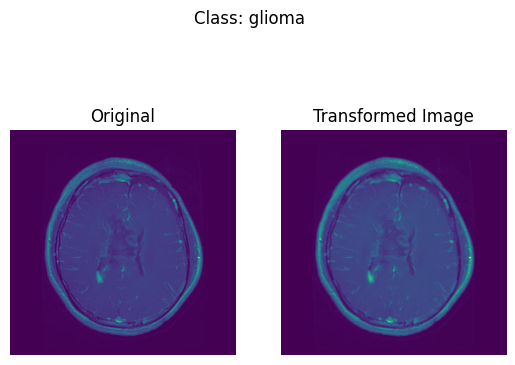

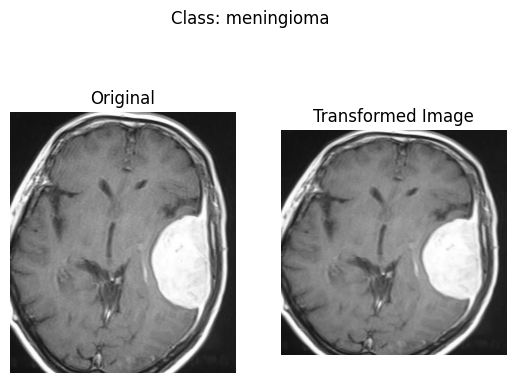

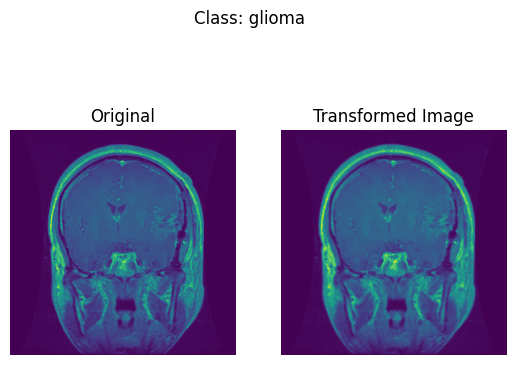

In [9]:
def plot_random(image_path_list,transform,n=3,seed=0):
    # sorted(image_path_list)
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path_list,k=n)

    for i in random_image_paths:
        # t = i.parent.stem
        with Image.open(i) as img:
            fig,ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(img)
            ax[0].set_title("Original")
            ax[0].axis("off")

            transform_img = transform(img)
            ax[1].imshow(transform_img.permute(1,2,0))
            ax[1].set_title("Transformed Image")
            ax[1].axis("off")

            fig.suptitle(f"Class: {i.parent.stem}")
    plt.show()


plot_random(images,data_transform,3)

In [10]:
def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))
    

train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transform, loader=safe_pil_loader)
test_dataset= datasets.ImageFolder(root=test_dir,transform=data_transform, loader=safe_pil_loader)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

len(train_dataset), len(test_dataset), len(train_dataloader), len(test_dataloader)

(5712, 1311, 179, 41)

In [13]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt


model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=6,
    ignore_mismatched_sizes=True
)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for param in model.parameters():
    param.requires_grad = False

classifier_params = model.module.classifier.parameters() if isinstance(model, torch.nn.DataParallel) else model.classifier.parameters()
for param in classifier_params:
    param.requires_grad = True

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_model = []
train_acc_model = []
test_loss_model = []
test_acc_model = []

EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model.train()

    train_loss_epoch = 0
    train_acc_epoch = 0

    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model(X).logits
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")

    train_loss_epoch /= len(train_dataloader)
    train_acc_epoch /= len(train_dataloader)

    model.eval()
    test_loss_epoch = 0
    test_acc_epoch = 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc

    test_loss_epoch /= len(test_dataloader)
    test_acc_epoch /= len(test_dataloader)

    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")


    train_loss_model.append(train_loss_epoch)
    train_acc_model.append(train_acc_epoch)
    test_loss_model.append(test_loss_epoch)
    test_acc_model.append(test_acc_epoch)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs


  0%|          | 0/5 [00:00<?, ?it/s]

1/5.........
Batch 0 | Train loss: 1.77545 | Train acc: 0.12
Batch 50 | Train loss: 1.12037 | Train acc: 0.44
Batch 100 | Train loss: 0.82399 | Train acc: 0.72
Batch 150 | Train loss: 0.80225 | Train acc: 0.78
Train loss: 1.01681 | Train acc: 0.63 | Test loss: 0.85743 | Test acc: 0.69
2/5.........
Batch 0 | Train loss: 0.76352 | Train acc: 0.78
Batch 50 | Train loss: 0.74100 | Train acc: 0.84
Batch 100 | Train loss: 0.79939 | Train acc: 0.66
Batch 150 | Train loss: 0.53925 | Train acc: 0.81
Train loss: 0.71554 | Train acc: 0.77 | Test loss: 0.73001 | Test acc: 0.73
3/5.........
Batch 0 | Train loss: 0.44887 | Train acc: 0.88
Batch 50 | Train loss: 0.69689 | Train acc: 0.75
Batch 100 | Train loss: 0.80715 | Train acc: 0.75
Batch 150 | Train loss: 0.50270 | Train acc: 0.88
Train loss: 0.61233 | Train acc: 0.80 | Test loss: 0.65977 | Test acc: 0.75
4/5.........
Batch 0 | Train loss: 0.71888 | Train acc: 0.72
Batch 50 | Train loss: 0.66890 | Train acc: 0.78
Batch 100 | Train loss: 0.60309 

In [14]:
torch.save(model.state_dict(),"/kaggle/working/model.pth")

print("Model 1 saved successfully!")

Model 1 saved successfully!


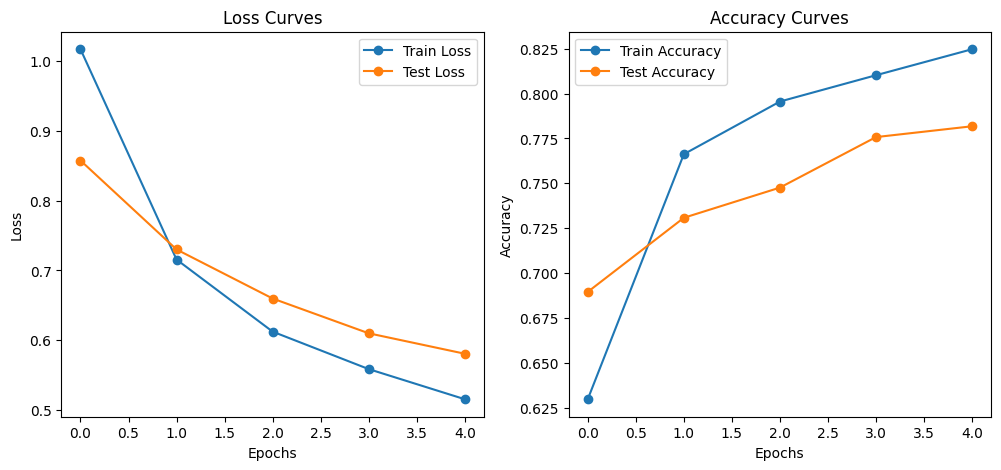

In [15]:
def plot_loss_curves(train_loss, train_acc, test_loss, test_acc, batches_per_epoch=1):
    num_epochs = len(train_loss)

    epochs = range(num_epochs)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

plot_loss_curves(train_loss_model, train_acc_model, test_loss_model, test_acc_model, batches_per_epoch=1)

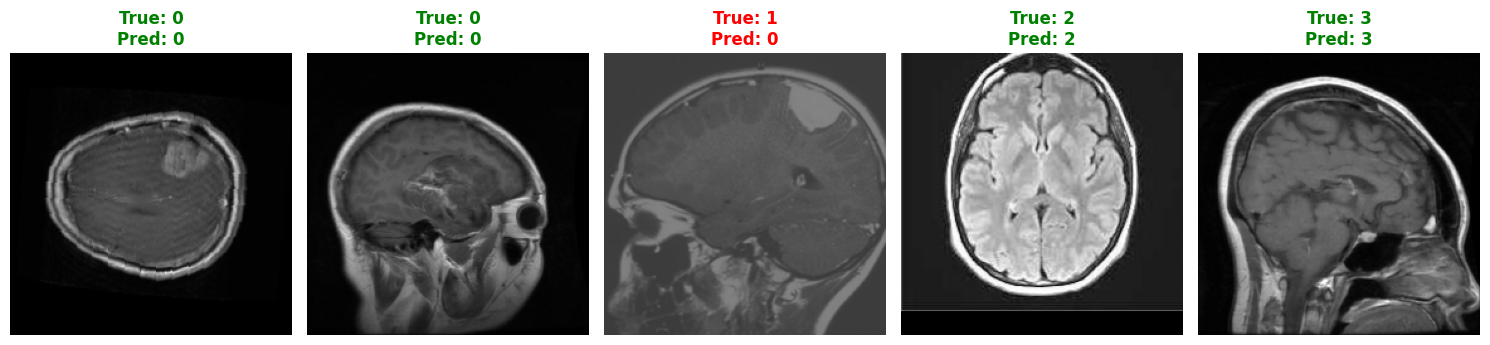

In [20]:
import random
import matplotlib.pyplot as plt
import numpy as np

def get_random_test_samples(test_dataloader, num_samples=10):
    test_batch = next(iter(test_dataloader))
    test_images, test_labels = test_batch
    
    random_indices = random.sample(range(len(test_images)), min(num_samples, len(test_images)))
    
    random_images = test_images[random_indices]
    random_labels = test_labels[random_indices]
    resize_transform = transforms.Resize((224, 224))
    random_images = torch.stack([resize_transform(img) for img in random_images])
    return random_images, random_labels

model.eval()

random_images, random_labels = get_random_test_samples(test_dataloader, num_samples=5)

with torch.no_grad():
    random_images = random_images.to(next(model.parameters()).device)
    
    pred_logits = model(random_images).logits
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

random_images = random_images.cpu()
random_labels = random_labels.cpu()
pred_labels = pred_labels.cpu()

plt.figure(figsize=(15, 10))
for i, (image, true_label, pred_label) in enumerate(zip(random_images, random_labels, pred_labels)):
    plt.subplot(1, 5, i+1)
    img = image.permute(1, 2, 0).numpy()
    
    if img.max() > 1.0:
        img = img / 255.0
    
    plt.imshow(img)
    
    correct = true_label.item() == pred_label.item()
    color = 'green' if correct else 'red'
    
    plt.title(f"True: {true_label.item()}\nPred: {pred_label.item()}", 
              color=color, fontweight='bold')
    
    if not correct:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        plt.gca().spines['top'].set_linewidth(3)
        plt.gca().spines['bottom'].set_linewidth(3)
        plt.gca().spines['left'].set_linewidth(3)
        plt.gca().spines['right'].set_linewidth(3)
    
    plt.axis("off")
plt.tight_layout()
plt.show()
_ = get_random_test_samples(test_dataloader, num_samples=10)

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Example: modify based on your dataset
plot_confusion_matrix(model=model, dataloader=test_dataloader, class_names=class_names, device=device)


KeyboardInterrupt: 